In [ ]:
import math
import random
import networkx as nx
import matplotlib.pyplot as plt
import os

# Các hàm tiện ích chung cho đồ thị
# in ma trận kề, nhập đỉnh, heuristic Euclid,
def print_adjacency_matrix(vertices, adj):
    """In ma trận kề có tiêu đề"""
    n = len(vertices)
    print("\nMa tran ke cua do thi:")
    print("    " + " ".join(vertices))
    for i in range(n):
        print(vertices[i] + " | " + " ".join(map(str, adj[i])))

# nhập đỉnh hợp lệ đỉnh bắt đầu và kết thúc
def input_vertex(vertices, msg):
    """Nhập đỉnh hợp lệ"""
    while True:
        v = input(msg).strip().upper()
        if v in vertices:
            return v
        print("Nhap sai. Cac dinh hop le:", vertices)

# heuristic Euclid giữa hai đỉnh
def heuristic(u, v, pos):
    """Heuristic Euclid"""
    return math.dist(pos[u], pos[v])# ước lượng chi phí từ đỉnh hiện tại đến đích

# sinh đồ thị ngẫu nhiên, random ma trận kề với trong số cạnh từ 1-9
def generate_random_graph(n, min_degree=2):
    vertices = [chr(ord('A') + i) for i in range(n)]
    adj = [[0]*n for _ in range(n)]

    for i in range(n):# Đảm bảo mỗi đỉnh có ít nhất trọng số tối thiểu
        while sum(1 for x in adj[i] if x > 0) < min_degree:# Đếm số cạnh hiện tại của đỉnh i
        # random một đỉnh bất kỳ kiểm tra đỉnh đó khác với đỉnh i và chưa có cạnh nối giữa hai đỉnh
            j = random.randint(0, n-1)
            if i != j and adj[i][j] == 0: 
                w = random.randint(1, 9)
                adj[i][j] = w 
                adj[j][i] = w

    G = nx.Graph() # Tạo đồ thị NetworkX từ ma trận kề
    for v in vertices:
        G.add_node(v)

    for i in range(n):
        for j in range(i+1, n):
            if adj[i][j] > 0:
                G.add_edge(vertices[i], vertices[j], weight=adj[i][j])

    return G, vertices, adj


def load_graph_from_txt(filename="graph.txt"):
    """Load đồ thị từ file txt"""
    with open(filename, "r", encoding="utf-8") as f:
        lines = [l.strip() for l in f if l.strip()]

    n = int(lines[0])
    vertices = lines[1].split()
    adj = [list(map(int, lines[i+2].split())) for i in range(n)]

    G = nx.Graph()
    for v in vertices:
        G.add_node(v)

    for i in range(n):
        for j in range(i+1, n):
            if adj[i][j] > 0:
                G.add_edge(vertices[i], vertices[j], weight=adj[i][j])

    return G, vertices, adj

# xây dựng đường đi tạm thời từ cha đến con
def build_current_path(parent, current):
    """Dựng đường đi tạm thời"""
    path = [current]
    while parent[current] is not None:
        current = parent[current]
        path.append(current)
    return list(reversed(path))


def draw_step(G, pos, step, path_so_far=None):
    """Vẽ đồ thị từng bước, tô đỏ các cạnh đã đi"""
    plt.figure(figsize=(3, 3))

    nx.draw(
        G, pos,
        with_labels=True,
        node_size=550,
        node_color="orange",
        edge_color="black"
    )

    edge_labels = nx.get_edge_attributes(G, 'weight')# Lấy nhãn trọng số cạnh
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels) # Vẽ nhãn trọng số cạnh
    # Tô đỏ các cạnh trong đường đi đã đi
    if path_so_far and len(path_so_far) > 1:
        edges_path = list(zip(path_so_far[:-1], path_so_far[1:]))
        nx.draw_networkx_edges(
            G, pos,
            edgelist=edges_path,
            edge_color="red",
            width=3
        )

    plt.title(f"Step {step}")
    os.makedirs("steps", exist_ok=True) # Tạo thư mục lưu ảnh nếu chưa tồn tại
    plt.savefig(f"steps/step_{step}.png")
    plt.show()


In [5]:
class AStar:
    def __init__(self, graph):
        self.graph = graph
        self.pos = nx.spring_layout(graph, seed=42)

    def h(self, node, goal):
        return heuristic(node, goal, self.pos)

    def f(self, node, g_cost, goal):
        return g_cost[node] + self.h(node, goal)

    def reconstruct_path(self, parent, goal):
        path = [goal]
        while parent[goal] is not None:
            goal = parent[goal]
            path.append(goal)
        return list(reversed(path))

    def solve(self, start, goal):
        open_list = set([start])
        closed_list = set()

        g_cost = {start: 0}
        parent = {start: None}

        step = 0

        while open_list:
            # Hiển thị OPEN / CLOSED
            print("\nOPEN LIST:")
            for node in open_list:
                print(f"  {node}: g={g_cost[node]}, f={round(self.f(node, g_cost, goal), 2)}")
            print("CLOSED LIST:", closed_list)

            # Chọn node có f nhỏ nhất
            n = None
            for node in open_list:
                if n is None or self.f(node, g_cost, goal) < self.f(n, g_cost, goal):
                    n = node

            step += 1
            print(f"\nBuoc {step}:")
            print(f"Chon dinh: {n}")
            print(f"g({n}) = {g_cost[n]}")
            print(f"f({n}) = {round(self.f(n, g_cost, goal), 2)}")

            current_path = build_current_path(parent, n)
            draw_step(self.graph, self.pos, step, current_path)

            if n == goal:
                print("→ GOAL duoc chon voi f nho nhat")
                return self.reconstruct_path(parent, goal)

            print("Mo cac dinh ke:")

            for m in self.graph.neighbors(n):
                if m in closed_list:
                    continue

                w = self.graph[n][m]['weight']
                tentative_g = g_cost[n] + w
                print(f"  g({n} -> {m}) = {g_cost[n]} + {w} = {tentative_g}")

                if m not in open_list:
                    open_list.add(m)
                    parent[m] = n
                    g_cost[m] = tentative_g
                else:
                    if tentative_g < g_cost[m]:
                        g_cost[m] = tentative_g
                        parent[m] = n

            open_list.remove(n)
            closed_list.add(n)

        return None



A* SEARCH
1. Random graph
2. Load graph from file (.txt)
0. Thoat

Ma tran ke cua do thi:
    A B C D E
A | 0 1 5 1 0
B | 1 0 0 7 6
C | 5 0 0 0 6
D | 1 7 0 0 0
E | 0 6 6 0 0
Nhap sai. Cac dinh hop le: ['A', 'B', 'C', 'D', 'E']
Nhap sai. Cac dinh hop le: ['A', 'B', 'C', 'D', 'E']

Thong tin bai toan:
Start: A
Goal : D

OPEN LIST:
  A: g=0, f=1.38
CLOSED LIST: set()

Buoc 1:
Chon dinh: A
g(A) = 0
f(A) = 1.38


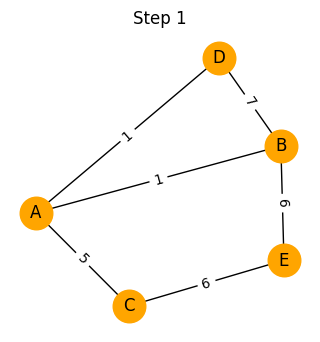

Mo cac dinh ke:
  g(A -> B) = 0 + 1 = 1
  g(A -> C) = 0 + 5 = 5
  g(A -> D) = 0 + 1 = 1

OPEN LIST:
  C: g=5, f=6.83
  D: g=1, f=1.0
  B: g=1, f=1.69
CLOSED LIST: {'A'}

Buoc 2:
Chon dinh: D
g(D) = 1
f(D) = 1.0


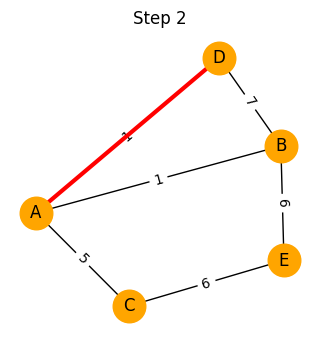

→ GOAL duoc chon voi f nho nhat

Duong di tim duoc:
A -> D

A* SEARCH
1. Random graph
2. Load graph from file (.txt)
0. Thoat

Ma tran ke cua do thi:
    A B C D E F
A | 0 2 0 1 0 0
B | 2 0 3 2 0 0
C | 0 3 0 0 1 0
D | 1 2 0 0 3 4
E | 0 0 1 3 0 2
F | 0 0 0 4 2 0

Thong tin bai toan:
Start: A
Goal : D

OPEN LIST:
  A: g=0, f=1.1
CLOSED LIST: set()

Buoc 1:
Chon dinh: A
g(A) = 0
f(A) = 1.1


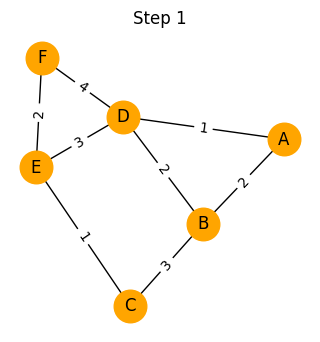

Mo cac dinh ke:
  g(A -> B) = 0 + 2 = 2
  g(A -> D) = 0 + 1 = 1

OPEN LIST:
  D: g=1, f=1.0
  B: g=2, f=2.88
CLOSED LIST: {'A'}

Buoc 2:
Chon dinh: D
g(D) = 1
f(D) = 1.0


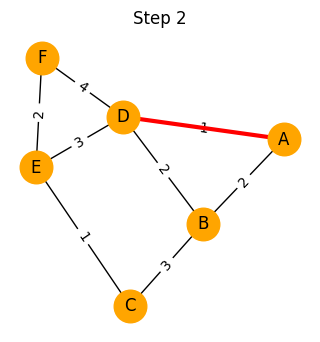

→ GOAL duoc chon voi f nho nhat

Duong di tim duoc:
A -> D

A* SEARCH
1. Random graph
2. Load graph from file (.txt)
0. Thoat
Ket thuc chuong trinh.


In [6]:
def main():
    while True:
        print("\n==========================")
        print("A* SEARCH")
        print("1. Random graph")
        print("2. Load graph from file (.txt)")
        print("0. Thoat")
        choice = input("Chon (0/1/2): ").strip()

        if choice == "0":
            print("Ket thuc chuong trinh.")
            break

        elif choice == "1":
            while True:
                n = input("Nhap so dinh (3 <= n <= 10): ").strip()
                if n.isdigit() and 3 <= int(n) <= 10:
                    n = int(n)
                    break
                print("Nhap sai. Vui long nhap tu 3 den 10.")
            G, vertices, adj = generate_random_graph(n)

        elif choice == "2":
            G, vertices, adj = load_graph_from_txt("graph.txt")

        else:
            print("Lua chon khong hop le.")
            continue

        print_adjacency_matrix(vertices, adj)

        start = input_vertex(vertices, "Nhap dinh bat dau: ")
        goal = input_vertex(vertices, "Nhap dinh ket thuc: ")

        print("\nThong tin bai toan:")
        print("Start:", start)
        print("Goal :", goal)

        astar = AStar(G)
        path = astar.solve(start, goal)

        if path:
            print("\nDuong di tim duoc:")
            print(" -> ".join(path))
        else:
            print("\nKhong tim duoc duong di.")

        input("\nNhan Enter de thuc hien yeu cau khac...")


if __name__ == "__main__":
    main()
